## Observational Scoliosis Diagnosis with Deep Learning
### By Penelope Larkin

December 2022

### Abstract
This research notebook explores the possibility of diagnosing scoliosis with high accuracy from a single photo of a person's back taken with a consumer-grade camera, like a simple smartphone, instead of using an X-ray. The model is 76% successful on the validation set and the class activation maps confirms the model is learning medically relavent features. This model could be used in communities or countries where access to X-rays is limited or where medical staff has not been trained to detect scoliosis. Additionally, reducing the number of X-rays needed to assess and monitor patients’ conditions would lower costs and limit exposure to radiation.

This notebook is a self-directed research project. Thank you to InspiritAI for teaching me the fundamentals and fastai for providing highly accessible YouTube videos that helped me create this notebook.

### Methods
This notebook is a “Jupyter notebook” which combines text, images, code, and output. I built a computer vision model using [PyTorch](http:/pytorch.org/) and the [fastai framework](https://github.com/fastai/fastai) and trained it on a small public dataset of 14 images and 50 images I collected myself via Google image search. Given the small number of images, I took a “transfer learning” approach and used a convolutional neural network (ResNet18) which was pre-trained on the [ImageNet dataset](https://www.image-net.org/about.php). I withheld 33% of the images as a validation set and fine-tuned the model on the remaining images. To ensure robustness and avoid overfitting, I used several randomized data augmentation transformations including left-to-right image flipping, slight rotations, brightness adjustments, and "MixUp."  

### Imports

In [1]:
from fastai.vision.all import *
import shutil

In [2]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(27)

### Data Cleaning
I first used a publicly available dataset on Kaggle Datasets. This dataset turned out to only have 14 unique images. The duplicates were checked in another notebook. I then combined it with manually collected data. The resulting dataset has 64 images. 

In [3]:
good_no = [
    '/kaggle/input/scoliosis-screening-no/20 (14).jpg',
    '/kaggle/input/scoliosis-screening-no/23 (8).jpg',
    '/kaggle/input/scoliosis-screening-no/30 (13).jpg',
    '/kaggle/input/scoliosis-screening-no/36 (23).jpg',
    '/kaggle/input/scoliosis-screening-no/42 (53).jpg'
          ]
good_yes = [
    '/kaggle/input/scoliosis-back-images-yes/21 (10).jpg',
    '/kaggle/input/scoliosis-back-images-yes/21 (3).jpg',
    '/kaggle/input/scoliosis-back-images-yes/22 (5).jpg',
    '/kaggle/input/scoliosis-back-images-yes/22 (7).jpg',
    '/kaggle/input/scoliosis-back-images-yes/23 (8).jpg',
    '/kaggle/input/scoliosis-back-images-yes/27 (9).jpg',
    '/kaggle/input/scoliosis-back-images-yes/28 (12).jpg',
    '/kaggle/input/scoliosis-back-images-yes/28 (16).jpg',
    '/kaggle/input/scoliosis-back-images-yes/30 (31).jpg'
]

In [4]:
!mkdir scoli_yes
!mkdir scoli_no

In [5]:
for fname in good_no:
     destFileName = str(fname).split('/')[-1]
     shutil.copyfile(str(fname), '/kaggle/working/scoli_no/' + destFileName)

for fname in good_yes:
     destFileName = str(fname).split('/')[-1]
     shutil.copyfile(str(fname), '/kaggle/working/scoli_yes/' + destFileName)

!cp /kaggle/input/scoli-pt-2/No/* /kaggle/working/scoli_no
!cp /kaggle/input/scoli-pt-2/Yes/* /kaggle/working/scoli_yes

In [6]:
path_no = '/kaggle/working/scoli_no/'
path_yes = '/kaggle/working/scoli_yes/'

fnames_no = get_image_files(path_no)
fnames_yes = get_image_files(path_yes)

To give a sense of what these images look like, I pulled two sample images. The first image is a "No" diagnosis and the second image is a "Yes" diagnosis. To the untrained eye, many of the the diagnoses are not obvious.

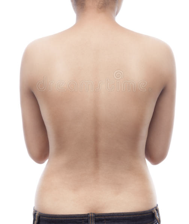

In [7]:
im = Image.open(fnames_no[1])
im.to_thumb(224,224)

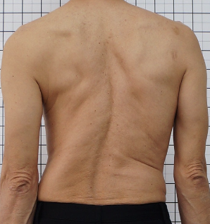

In [8]:
im = Image.open(fnames_yes[1])
im.to_thumb(224,224)

### DataBlock and DataLoader
I set up the labeling function for the images and the fastai DataBlock data structure which includes the data augmentation transformations. I then showed a sample batch of 6 images; the images shown are the raw images after any randomized transformations.

In [9]:
def parent_label(fileName):
    if ("yes" in str(fileName)):
        return "yes"
    else:
        return "no"

In [10]:
path = Path('/kaggle/working')
dls = DataBlock (
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.33),
    get_y=parent_label,
    item_tfms=[
        # resize the images to fit into the
        # pre-trained ResNet
        Resize(224, method='squish'), 
        # randomly flip the image left-to-right
        FlipItem(p=.50)],
    batch_tfms=[
        # randomly rotate the image from -2 to 2 degrees
        Rotate(max_deg=2, p=1), 
        # apply brigten or darken
        Brightness(max_lighting=0.2, p=1)]
).dataloaders(path, bs=6, num_workers = 0)
seed_everything(27)

In [11]:
len(dls.train_ds), len(dls.valid_ds)

(43, 21)

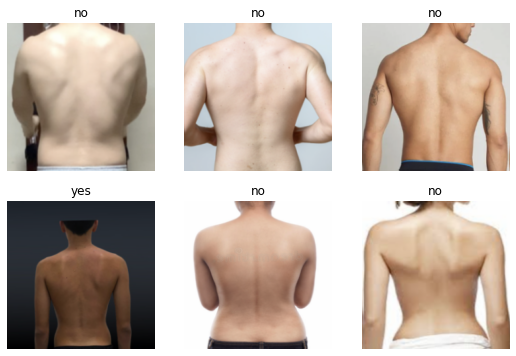

In [12]:
dls.show_batch()

### Model Creation
I instantiated the model, a Fastai `vision_learner`, by passing in the Dataloader, the model architecture, and the metrics we want displayed in training. For the model architecture, I chose the ResNet18. The ResNet was introduced in 2015 by Kaiming He et al. and introduced the skip connection where each subsequent model layer was provided with the residual of the prior layer. Before this innovation, it was known in theory that deeper networks should be better, but that was not observed in practice. The ResNet architecture allows the network to learn more complex features while still being able to effectively optimize a model with a large number of layers during training. The “18” refers to the number of convolutional layers in the model. Fastai also adds a modified model head. ResNet18 is trained for the 1,000 ImageNet classes. In this dataset, there are two prediction classes: “Yes” or “No” for diagnosis. As such, Fastai removes the fully connected and softmax layers from the pretrained model and replaces them with a two class softmax and appropriately sized fully connected layer. Fastai also adds two layers of “dropout” to make the model more robust to overfitting. By default, when training, Fastai uses a cyclical learning rate, the Adam optimizer, batch normalization, and random initial weights in the head. 

In addition to using the accuracy as a metric, I also showed  the [F1 Score](https://en.wikipedia.org/wiki/F-score) because the classes are imbalanced in this dataset. The F1 Score is the harmonic mean between the precision, $P$, which answers “What proportion of positive identifications was actually correct?”, and the recall, $R$, which answers “What proportion of actual positives was identified correctly?”. The F1 score is robust to class imbalance. Mathematically,

$$P = \frac{TP}{TP+FP}$$
$$R = \frac{TP}{TP+FN}$$
$$F1 = \frac{2(P \times R)}{(P + R)}$$

A higher F1 score is better and the maximum of the metric is 1.0. I used "MixUp" which combines the images and their labels which is a helpful data augmentation technique when the dataset is small. "MixUP" is described in the [paper](http://doi.org/10.48550/arXiv.1710.09412) by Zhang, Hongyi, et al.

In [13]:
%%capture

learn = None

learn = vision_learner(dls, resnet18, metrics=[accuracy, F1Score()], cbs=MixUp(alpha=1.))

I inspected different segments of the model.

In [14]:
# the image come into this first layer
learn.model[0][0:4]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
)

In [15]:
# then they pass through ResNet blocks
# PyTorch calls this a Basic Block
learn.model[0][4][0]

BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [16]:
# Fastai Model head
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [17]:
dls.vocab

['no', 'yes']

### Model Training
I fine tuned the model to adjust the weights and to teach the model the differences between my dataset and the ImageNet dataset. I trained for 9 epochs. 

In [18]:
learn.fine_tune(9)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.224075,0.679704,0.523810,0.583333,00:06


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.943100,0.562700,0.666667,0.740741,00:01
1,0.944325,0.579353,0.571429,0.571429,00:01
2,0.884821,0.593913,0.761905,0.761905,00:01
3,0.795527,0.828136,0.619048,0.600000,00:01
4,0.779014,0.900399,0.571429,0.571429,00:01
5,0.775043,1.010299,0.476190,0.476190,00:01
6,0.768521,1.103767,0.476190,0.476190,00:01
7,0.747498,1.060370,0.476190,0.476190,00:01
8,0.834149,1.021219,0.476190,0.476190,00:01


### Model Validation
I found the first image where the model is over 98% confident in the diagnosis for each class. 

In [19]:
%%capture
i = 0
while (learn.predict(fnames_no[i])[2][0] < 0.98):
    i = i+1

j = 0
while (learn.predict(fnames_yes[j])[2][1] < 0.98):
    j = j+1

In [20]:
learn.predict(fnames_no[i])

('no', TensorBase(0), TensorBase([0.9969, 0.0031]))

In [21]:
learn.predict(fnames_yes[j])

('yes', TensorBase(1), TensorBase([4.3707e-04, 9.9956e-01]))

The confusion matrix shows the count of true positives and true negatives on the diagonal and count of errors elsewhere. While the model was not perfect, the true positives and true negatives far exceed the false positives and false negatives.

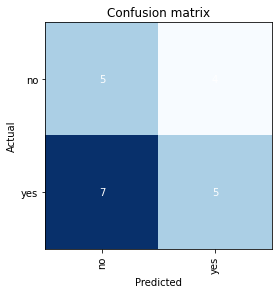

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Explainability: Class Activation Map Interpretations

It is not just necessary to validate the model on the validation set using metrics, but also to be able to **explain** why the model comes to its conclusion. It is important to ensure that the model is not learning features that are not, in fact, important to the problem. For example, in one paper, ["Why Should I Trust You?": Explaining the Predictions of Any Classifier](https://arxiv.org/abs/1602.04938), the authors trained a classifier to distinguish between wolves and huskies (which look very similar to the untrained eye). The model appears to work well when looking at the metrics on the validation set, but in fact, the distinguishing feature it learns is that in the images of wolves, there is snow! That model therefore is simply classifying an image with snow as a wolf and an image without snow as husky.

In this notebook, I use the class activation map (CAM), introduced by Bolei Zhou et al. in [Learning Deep Features for Discriminative Localization](https://arxiv.org/abs/1512.04150). This method uses the output of the last convolutional layer and class weights from the final linear layer to display a heatmap visualization of why the model made its decision. The output of the last convolutional layer contains all the final feature maps that the model thinks are important to make the classification. CAM shows how each pixel in the image contributed to the model class prediction. To do this, it takes the feature maps from the last convolutional layer and does a weighted sum where the weights are the learned weights in the final fully connected layer for the predicted class. This weighted sum is then overlaid onto the image. This is process is illustrated in the Zhou et al. paper in Figure 2:

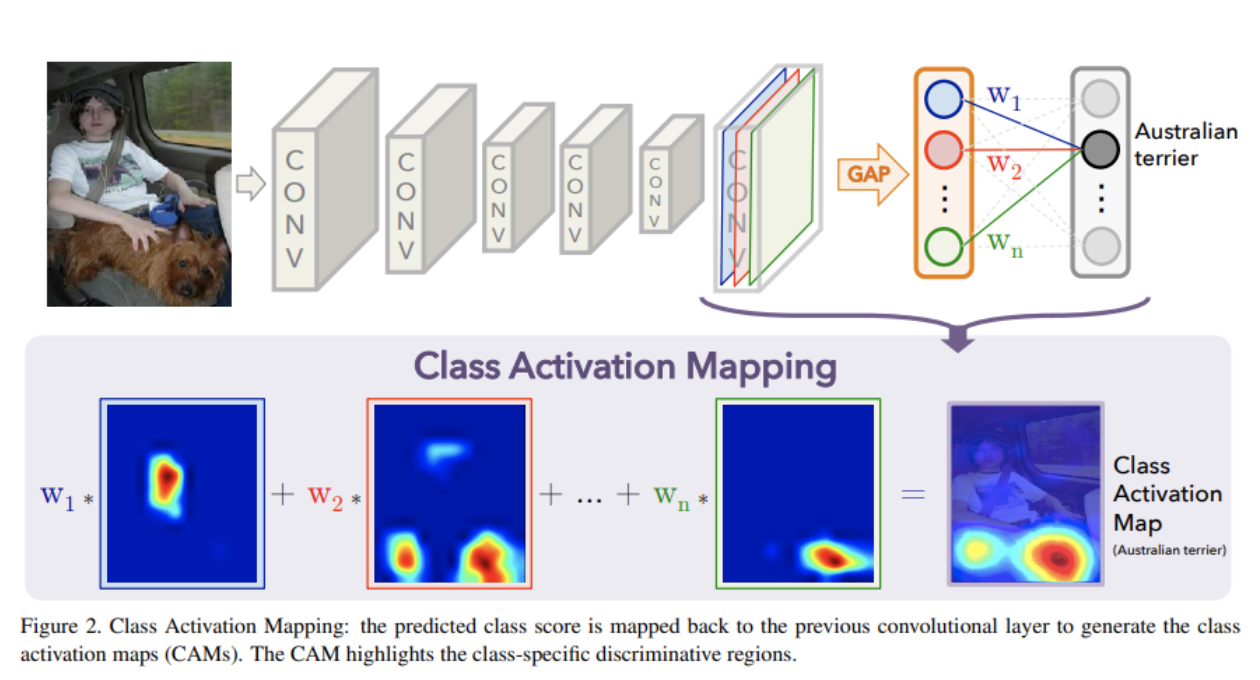

The code for this section is based on [Chapter 18 of Practical Deep Learning for Coders](https://github.com/fastai/fastbook/blob/master/18_CAM.ipynb), but modified to take an arbitrary class. The first step is to create a PyTorch “hook” which is code that runs at a specific point in the model execution. The hook here stores the model activations during a forward pass from the last convolutional layer into the variable `act`. The class weights from the final linear layer are retrieved with `learn.model[1][-1].weight`. Then these two matrices are multiplied together using the `einsum` function.

The light colored area is where the model is looking.

In [23]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [24]:
hook_output = Hook()
hook = learn.model[0].register_forward_hook(hook_output.hook_func)

Created function to view the heatmap visualization.

In [25]:
def plot_explanation(learn, fname, diagnosis):
    x, = first(dls.test_dl([fname]))
    with torch.no_grad(): output = learn.model.eval()(x)
    act = hook_output.stored[0]
    cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
    x_dec = TensorImage(dls.train.decode((x,))[0][0])
    _,ax = plt.subplots()
    x_dec.show(ctx=ax)
    ax.imshow(cam_map[diagnosis].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');
    ax.set_title(parent_label(fname));

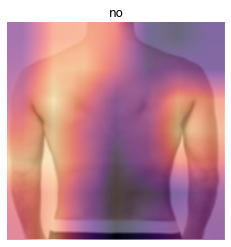

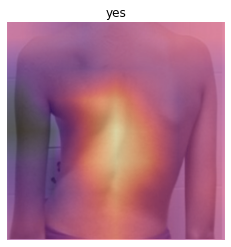

In [26]:
plot_explanation(learn, fnames_no[0], 0)
plot_explanation(learn, fnames_yes[3], 1)

These CAM images are very encouraging because we can see that in both a positive and negative prediction, the model looks primarily at areas of the back that makes sense for scoliosis diagnosis: the shoulder blades and spine.

### Limitations, Ethical Considerations, and Next Steps

The dataset I am using is made up, in part, by a dataset published in Kaggle Datasets, however there is no provenance or description, and I do not know the circumstances under which the data was collected. I have contacted the publisher of the dataset to get clarity on these questions but have not heard back. The remainder of the data I collected via Google image search. Likewise, we cannot be certain if these images were accurately classified. Because of lack of clarity on the data, the results presented here can only be considered preliminary and this research notebook should be considered a proof-of-concept. This study should be repeated on a dataset where the images and labels have been collected and validated by trained medical staff. Additionally, the dataset should contain diverse images across gender, race, and skin color in order to ensure that the model is not biased. A follow-up study that could be done is to see if a model can accurately measure the Cobb angle (degree of the spinal curvature) from photos. To conduct this study, we would need actual curve measurements in addition to class labels. I hope to work with a pediatric orthopedics group at a hospital to further this work.

This notebook was run on the Kaggle Notebooks platform using a Nvidia Tesla P100 GPU.

### Sources

- He, Kaiming, et al. Deep Residual Learning for Image Recognition. 2015. DOI.org - (Datacite),
    https://doi.org/10.48550/ARXIV.1512.03385.

- Howard, J., & Gugger, S. (2020). Deep Learning for Coders with Fastai and PyTorch (1st ed.).
    O'Reilly Media. https://github.com/fastai/fastbook

- Ribeiro, Marco Tulio, et al. “Why Should I Trust You?”: Explaining the Predictions of Any
    Classifier. 2016. DOI.org (Datacite), https://doi.org/10.48550/ARXIV.1602.04938.
    
- Zhang, Hongyi, et al. Mixup: Beyond Empirical Risk Minimization. arXiv, 27 Apr. 2018. arXiv.org, https://doi.org/10.48550/arXiv.1710.09412.

- Zhou, Bolei, et al. Learning Deep Features for Discriminative Localization. 2015. DOI.org
    (Datacite), https://doi.org/10.48550/ARXIV.1512.04150.